# DiscreteFactorGraph

GTSAM Copyright 2010-2022, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved

Authors: Frank Dellaert, et al. (see THANKS for the full author list)

See LICENSE for the license information

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/discrete/doc/DiscreteFactorGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import google.colab
    %pip install --quiet gtsam
except ImportError:
    pass  # Not running on Colab, do nothing

A `DiscreteFactorGraph` is a factor graph consisting of `DiscreteFactor`s, such as `DecisionTreeFactor`. It represents a joint probability distribution (or a general function) over a set of discrete variables as a product of factors:
$$ P(X_1, ..., X_n) \propto \prod_i f_i(\text{Scope}_i) $$
where each $f_i$ is a factor over a subset of the variables (its scope).

This is an undirected graphical model (a Markov Random Field), and it is used to perform inference tasks like finding the most likely state (`optimize`) or computing marginals (via elimination).

In [2]:
import gtsam
import numpy as np
import graphviz

from gtsam.symbol_shorthand import X, Y, Z

## Creating a DiscreteFactorGraph

A `DiscreteFactorGraph` is created by adding `DiscreteFactor`s. We will create a simple graph with three variables and three factors.

In [3]:
# Define keys for three binary variables
KeyX = (X(0), 2)
KeyY = (Y(0), 2)
KeyZ = (Z(0), 2)

# Create an empty Factor Graph
dfg = gtsam.DiscreteFactorGraph()

# Add a unary factor on X (a prior)
dfg.add(KeyX, "0.3 0.7")

# Add a binary factor on X and Y
# Values for (X,Y) = (0,0), (0,1), (1,0), (1,1)
dfg.add([KeyX, KeyY], "0.5 0.2 0.1 0.9")

# Add a binary factor on Y and Z
# Values for (Y,Z) = (0,0), (0,1), (1,0), (1,1)
dfg.add([KeyY, KeyZ], "0.8 0.1 0.3 0.6")

print("Manually Constructed DiscreteFactorGraph:")
dfg.print()

Manually Constructed DiscreteFactorGraph:

size: 3
factor 0:  f[ (x0,2), ]
 Choice(x0) 
 0 Leaf  0.3
 1 Leaf  0.7
factor 1:  f[ (x0,2), (y0,2), ]
 Choice(y0) 
 0 Choice(x0) 
 0 0 Leaf  0.5
 0 1 Leaf  0.1
 1 Choice(x0) 
 1 0 Leaf  0.2
 1 1 Leaf  0.9
factor 2:  f[ (y0,2), (z0,2), ]
 Choice(z0) 
 0 Choice(y0) 
 0 0 Leaf  0.8
 0 1 Leaf  0.3
 1 Choice(y0) 
 1 0 Leaf  0.1
 1 1 Leaf  0.6


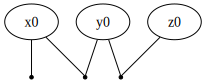

In [4]:
# Visualize the Factor Graph structure
# Circles are variables, squares are factors.
graphviz.Source(dfg.dot())

### Rich Display in Jupyter
A factor graph can be displayed as a list of its component factor tables.

In [5]:
dfg

size: 3
factor 0:  f[ (x0,2), ]
 Choice(x0) 
 0 Leaf  0.3
 1 Leaf  0.7
factor 1:  f[ (x0,2), (y0,2), ]
 Choice(y0) 
 0 Choice(x0) 
 0 0 Leaf  0.5
 0 1 Leaf  0.1
 1 Choice(x0) 
 1 0 Leaf  0.2
 1 1 Leaf  0.9
factor 2:  f[ (y0,2), (z0,2), ]
 Choice(z0) 
 0 Choice(y0) 
 0 0 Leaf  0.8
 0 1 Leaf  0.3
 1 Choice(y0) 
 1 0 Leaf  0.1
 1 1 Leaf  0.6

## Inference on a DiscreteFactorGraph

In [6]:
# --- Evaluation ---
# Calculate the product of all factor values for a given assignment.
values = gtsam.DiscreteValues()
values[X(0)] = 1
values[Y(0)] = 1
values[Z(0)] = 0

# P(X=1,Y=1,Z=0) ∝ f1(1) * f2(1,1) * f3(1,0)
#                  = 0.7  *   0.9   *   0.3 = 0.189
prob = dfg(values)
print(f"Unnormalized probability at (X=1, Y=1, Z=0): {prob:.4f}")

# --- Optimization (MPE) ---
# Find the assignment with the highest product of probabilities.
# This is done using the max-product algorithm (belief propagation).
mpe_solution = dfg.optimize()
print("\nMost Probable Explanation (MPE) Solution:")
print(mpe_solution)

Unnormalized probability at (X=1, Y=1, Z=0): 0.1890

Most Probable Explanation (MPE) Solution:
DiscreteValues{8646911284551352320: 1, 8718968878589280256: 1, 8791026472627208192: 1}


In [7]:
# --- Elimination (Sum-Product) ---
# Eliminate variables from the graph to obtain a Bayes Net (or just a marginal).
# This computes the marginal probability distribution.
ordering = gtsam.Ordering()
ordering.push_back(Z(0))
ordering.push_back(X(0))
ordering.push_back(Y(0))

# Eliminating the graph produces a Bayes Net P(X,Y,Z) = P(Z|Y)P(Y|X)P(X)
bayes_net = dfg.eliminateSequential(ordering)
print("--- Resulting Bayes Net after elimination ---")
bayes_net

--- Resulting Bayes Net after elimination ---


DiscreteBayesNet
 
size: 3
conditional 0:  P( x0 | y0 ):
 Choice(y0) 
 0 Choice(x0) 
 0 0 Leaf 0.68181818
 0 1 Leaf 0.31818182
 1 Choice(x0) 
 1 0 Leaf 0.086956522
 1 1 Leaf 0.91304348

conditional 1:  P( z0 | y0 ):
 Choice(z0) 
 0 Choice(y0) 
 0 0 Leaf 0.88888889
 0 1 Leaf 0.33333333
 1 Choice(y0) 
 1 0 Leaf 0.11111111
 1 1 Leaf 0.66666667

conditional 2:  P( y0 ):
 Choice(y0) 
 0 Leaf 0.24175824
 1 Leaf 0.75824176

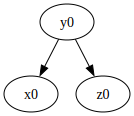

In [8]:
# Visualize the Bayes net structure using graphviz
graphviz.Source(bayes_net.dot())

In [9]:
# --- Elimination into a Bayes tree (Sum-Product) ---
# We can also produce a Bayes tree, which is typically more efficient to do.
bayes_tree = dfg.eliminateMultifrontal(ordering)
print("--- Resulting Bayes Tree after elimination ---")
bayes_tree

--- Resulting Bayes Tree after elimination ---


x0,y0,value
0,0,0.164835
0,1,0.0659341
1,0,0.0769231
1,1,0.692308
y0,0,1
0,0.888889,0.111111
1,0.333333,0.666667


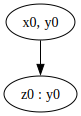

In [10]:
# Visualize the Bayes tree structure using graphviz
graphviz.Source(bayes_tree.dot())